In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [3, 3]

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [2]:
LATENT_DIMS = 16384
BATCH_SIZE = 2
IMAGE_SIZE = 512

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

# Create train,test and validation datasets
train_data = datasets.ImageFolder('./afhq/train/',data_transforms['train'])
val_data = datasets.ImageFolder('./afhq/val/',data_transforms['val'])

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
class_names = train_data.classes

print("Train dataset size --- ",len(train_data))
print("Val dataset size --- ",len(val_data))
print("Class_names --- ",class_names)

Train dataset size ---  14630
Val dataset size ---  1500
Class_names ---  ['cat', 'dog', 'wild']


In [23]:
train_iter = iter(train_loader)
X,Y = next(train_iter)
print(X.shape)
print(Y.shape)

torch.Size([2, 3, 512, 512])
torch.Size([2])


In [7]:
print(X.max())
print(X.min())

tensor(1.)
tensor(0.)


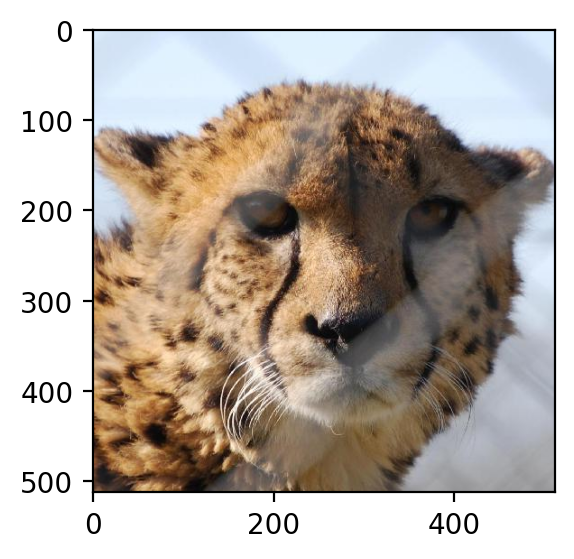

In [8]:
# When pixel values are in range 0-1
plt.imshow(X[0].permute(1,2,0))

In [3]:
class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, stride = 2,kernel_size=3):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channel_in, out_channels=channel_out // 2, kernel_size=kernel_size, stride=stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(in_channels=channel_out // 2, out_channels=channel_out, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return self.act_fnc(self.bn2(x + skip))
    

class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, upsample = True,scale_factor=2):
        super(ResUp, self).__init__()

        self.upsample = upsample
        self.conv1 = nn.Conv2d(channel_in, out_channels=channel_in // 2, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        #self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.up_nn = nn.ConvTranspose2d(channel_in, channel_in, kernel_size=4, stride = 2, padding=1)

        self.act_fnc = nn.ELU()

    def forward(self, x):
        if self.upsample:
            x = self.up_nn(x)
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)

        return self.act_fnc(self.bn2(x + skip))

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self,in_channels = 3,latent_channels = 4):
        super(VariationalEncoder, self).__init__()
        self.block_out_channels = [128,256,512,512]
        self.conv_in = torch.nn.Conv2d(
            in_channels,
            self.block_out_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self.conv1 = ResDown(channel_in=self.block_out_channels[0],channel_out=self.block_out_channels[0],stride=2)

        self.conv2 = ResDown(channel_in=self.block_out_channels[0],channel_out=self.block_out_channels[1],stride=2)
        #self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = ResDown(channel_in=self.block_out_channels[1],channel_out=self.block_out_channels[2],stride=2)
        #self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = ResDown(channel_in=self.block_out_channels[2],channel_out=self.block_out_channels[3],stride=1)

        self.mid = ResDown(channel_in=self.block_out_channels[3],channel_out=self.block_out_channels[3],stride=1)

        self.conv_norm_out = nn.GroupNorm(num_channels=self.block_out_channels[-1], num_groups=32, eps=1e-6)
        self.conv_act = nn.SiLU()

        conv_out_channels = 2 * latent_channels
        self.conv_out = nn.Conv2d(self.block_out_channels[-1], conv_out_channels, 3, padding=1)

        self.quant_conv = nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)

        

    def forward(self, x):
        # x = (b,3,512,512)

        out = x
        out = self.conv_in(out) # (b,128,512,512)

        out = self.conv1(out) # (b,128,256,256)
        out = self.conv2(out) # (b,256,128,128)
        out = self.conv3(out) # (b,512,64,64)
        out = self.conv4(out) # (b,512,64,64)
        out = self.mid(out) # (b,512,64,64)
        out = self.conv_norm_out(out)
        out = self.conv_act(out)
        out = self.conv_out(out) # (b,8,64,64)

        moment = self.quant_conv(out)
        mean, logvar = torch.chunk(moment, 2, dim=1)



        return mean,logvar

In [11]:
model = VariationalEncoder(latent_channels=4)
def model_memory_size_in_MB(model):
    return sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)

print(f"Model size (in MB): {model_memory_size_in_MB(model)}")


Model size (in MB): 51.38629150390625


In [12]:
model = model.to(device)
mean,log_var = model(X.to(device))
print(mean.shape)
print(log_var.shape)

torch.Size([6, 4, 64, 64])
torch.Size([6, 4, 64, 64])


In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_channels = 4,out_channels = 3):
        super(Decoder, self).__init__()
        self.post_quant_conv = nn.Conv2d(latent_channels, latent_channels, 1)

        self.block_out_channels = [128,256,512,512]
        self.conv_in = nn.Conv2d(
            latent_channels,
            self.block_out_channels[-1],
            kernel_size=3,
            stride=1,
            padding=1,
        )
        

        self.mid = ResUp(channel_in=self.block_out_channels[-1],channel_out=self.block_out_channels[-1],upsample=False)

        self.deconv1 = ResUp(channel_in=self.block_out_channels[-1],channel_out=self.block_out_channels[-1],upsample=True)

        self.deconv2 = ResUp(channel_in=self.block_out_channels[-1],channel_out=self.block_out_channels[-2],upsample=True)

        self.deconv3 = ResUp(channel_in=self.block_out_channels[-2],channel_out=self.block_out_channels[-3],upsample=True)

        self.deconv4 = ResUp(channel_in=self.block_out_channels[-3],channel_out=self.block_out_channels[-4],upsample=False)

        

        self.conv_norm_out = nn.GroupNorm(num_channels=self.block_out_channels[0], num_groups=32, eps=1e-6)
        self.conv_act = nn.SiLU()
        self.conv_out = nn.Conv2d(self.block_out_channels[0], out_channels, 3, padding=1)


    def forward(self, z):
        # z = (b,4,64,64)
        out = self.conv_in(z) # (b,512,64,64)
        out = self.mid(out) # (b,512,64,64)


        out = self.deconv1(out) # (b,512,128,128)
        out = self.deconv2(out) # (b,512,256,256)
        out = self.deconv3(out) # (b,256,512,512)
        out = self.deconv4(out) # (b,128,512,512)
        
        out = self.conv_norm_out(out)
        out = self.conv_act(out)
        out = self.conv_out(out) # (b,3,512,512)
        
        return out



In [13]:
decoder = Decoder(latent_channels=4)
print(f"Model size (in MB): {model_memory_size_in_MB(decoder)}")

Model size (in MB): 136.2002830505371


In [15]:
decoder = decoder.to(device)
decoder(mean).shape

torch.Size([6, 3, 512, 512])

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_channels = 4):
        super(VariationalAutoencoder, self).__init__()
        self.latent_channels = latent_channels
        self.encoder = VariationalEncoder(latent_channels=latent_channels)
        self.decoder = Decoder(latent_channels=latent_channels)

        self.N = torch.distributions.Normal(0, 1)
        # self.N.loc = self.N.loc.cuda(0) # hack to get sampling on the GPU
        # self.N.scale = self.N.scale.cuda(0)

        #self.kl = 0.0
        #self.recon_loss = 0.0
    
    def reparametrize(self,mu,log_var):
        sigma = torch.exp(0.5*log_var)
        z = mu + sigma*(self.N.sample(mu.shape).to(sigma.device))
        return z
    
    def forward(self, x):
        # Bernoulli MLP
        z_mu,z_log_var = self.encoder(x)

        # z_sigma = torch.exp(0.5*z_log_var)
        # z = z_mu + z_sigma*self.N.sample(z_mu.shape)
        z = self.reparametrize(z_mu,z_log_var)
        self.KL = 0.5 * torch.sum(z_log_var.exp() + z_mu.pow(2) - z_log_var - 1.0,dim=[1, 2, 3]) / BATCH_SIZE
        #print(self.kl)

        x_hat = self.decoder(z)
        self.recon_loss = -F.mse_loss(x_hat, x, reduction='sum') / BATCH_SIZE
        #self.recon_loss = -F.binary_cross_entropy(x_hat, x, reduction='sum') / BATCH_SIZE

        return x_hat,self.KL,self.recon_loss

In [14]:
model = VariationalAutoencoder(latent_channels=4).to(device)
model(X.to(device)).shape

In [15]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('./runs/diffusers1')

In [16]:
autoencoder = VariationalAutoencoder(latent_channels=4).to(device) # GPU
opt = torch.optim.Adam(autoencoder.parameters(), lr= 1e-4)

rec_loss = []
KL_loss = []


In [17]:
autoencoder = torch.nn.DataParallel(autoencoder,device_ids = [0,1,3,4,5])
#autoencoder(X.to(device))[0].shape

In [18]:
epochs = 10

for epoch in range(epochs):
    iter = 0
    total_loss = 0.0
    total_rec_loss = 0.0
    total_KL_loss = 0.0
    for x, y in train_loader:
        iter+=1
        x = x*2.0 - 1.0
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat,KL,recon_loss = autoencoder(x)
        KL = torch.sum(KL)
        recon_loss = torch.sum(recon_loss)

        ELBO = recon_loss - KL
        # rec_loss.append(-autoencoder.recon_loss)
        # KL_loss.append(autoencoder.KL)
        loss = -ELBO
        total_loss +=loss
        total_rec_loss +=-recon_loss
        total_KL_loss +=KL
        loss.backward()
        
        opt.step()
        if iter%10 == 0:
            #print("Epoch == ",epoch,"Iter == ",iter,"  Loss == ",total_loss.item()/(iter))
            writer.add_scalar('Total_Loss/train', total_loss.item()/iter, epoch*len(train_loader)+iter)
            writer.add_scalar('Rec_Loss/train', total_rec_loss.item()/iter, epoch*len(train_loader)+iter)
            writer.add_scalar('KL_Loss/train', total_KL_loss.item()/iter, epoch*len(train_loader)+iter)
        if iter%50 == 0:
            print("Epoch == ",epoch,"Iter == ",iter,"  Loss == ",total_loss.item()/(iter))
            
    rec_loss.append(total_rec_loss.item()/len(train_loader))
    KL_loss.append(total_KL_loss.item()/len(train_loader))
    print("\n\nEpoch == ",epoch,"  Loss == ",total_loss.item()/len(train_loader))

/data4/home/manikantab/Diffusion_models/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch ==  0 Iter ==  50   Loss ==  82710.825
Epoch ==  0 Iter ==  100   Loss ==  65109.905
Epoch ==  0 Iter ==  150   Loss ==  57852.513333333336
Epoch ==  0 Iter ==  200   Loss ==  53738.675
Epoch ==  0 Iter ==  250   Loss ==  50247.28
Epoch ==  0 Iter ==  300   Loss ==  48566.16333333333
Epoch ==  0 Iter ==  350   Loss ==  46941.78857142857
Epoch ==  0 Iter ==  400   Loss ==  45374.505
Epoch ==  0 Iter ==  450   Loss ==  44331.80888888889
Epoch ==  0 Iter ==  500   Loss ==  43286.124
Epoch ==  0 Iter ==  550   Loss ==  42423.22909090909
Epoch ==  0 Iter ==  600   Loss ==  41904.12666666666
Epoch ==  0 Iter ==  650   Loss ==  41289.34153846154
Epoch ==  0 Iter ==  700   Loss ==  40748.20285714286
Epoch ==  0 Iter ==  750   Loss ==  40140.789333333334
Epoch ==  0 Iter ==  800   Loss ==  39575.335
Epoch ==  0 Iter ==  850   Loss ==  38993.2705882353
Epoch ==  0 Iter ==  900   Loss ==  38461.20888888889


Epoch ==  0   Loss ==  38359.16502732241
Epoch ==  1 Iter ==  50   Loss ==  30174.4

KeyboardInterrupt: 

In [24]:
import os
torch.save(autoencoder.module.state_dict(), os.path.join('./trained_models/diffuserscopy_checkpoint_{}.pth'.format(epoch)))

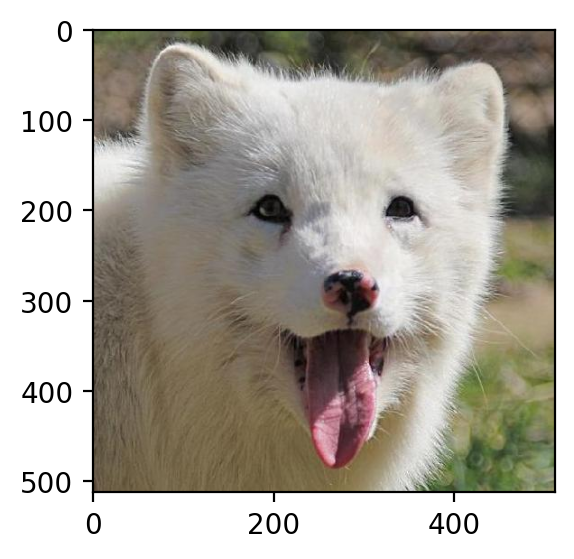

In [18]:
plt.imshow(X[6].permute(1,2,0))

In [14]:
model1 = VariationalAutoencoder(latent_channels=4).to('cuda:1')
model1.load_state_dict(torch.load('./trained_models/diffuserscopy_checkpoint_4.pth'))
model1.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): ResDown(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (conv2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_

cpu


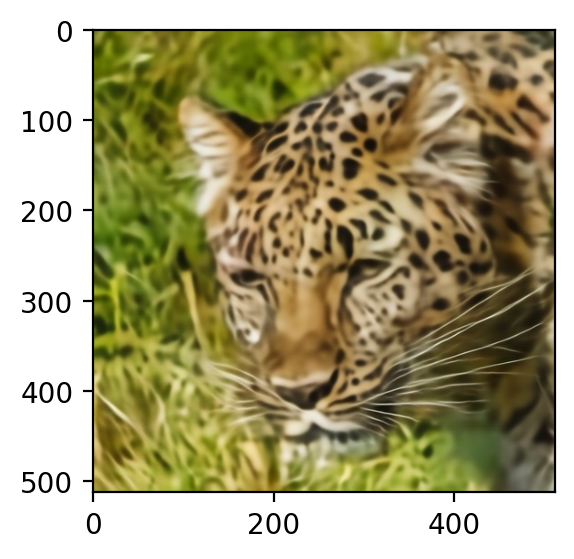

In [22]:
input = X[1].unsqueeze(0)*2.0 - 1.0

image = model1(input.to('cuda:1'))[0].squeeze(0).detach().cpu().permute(1,2,0)
image = (image / 2 + 0.5).clamp(0, 1) 
plt.imshow(image)

## Plotting grid

In [ ]:
model1.eval()

original_images = []
returned_images = []
iter = 0
for x, y in train_loader:
    iter+=1
    x = x*2.0 - 1.0
    x = x.to('cuda:1') # GPU
    x_hat,_,_ = model1(x)
    x_hat = (x_hat / 2 + 0.5).clamp(0, 1) 
    x = (x / 2 + 0.5).clamp(0, 1) 
    original_images.append(x.detach().cpu())
    returned_images.append(x_hat.detach().cpu())

    if len(original_images) * train_loader.batch_size >= 100:
            break

    

In [30]:
# # Convert lists of tensor batches into single tensors
import torchvision
original_images = torch.cat(original_images, dim=0)[:100]  # Taking first 100 images
returned_images = torch.cat(returned_images, dim=0)[:100]

# Create 10x10 grids
original_grid = torchvision.utils.make_grid(original_images, nrow=10, padding=2, normalize=True).cpu()
returned_grid = torchvision.utils.make_grid(returned_images, nrow=10, padding=2, normalize=True).cpu()

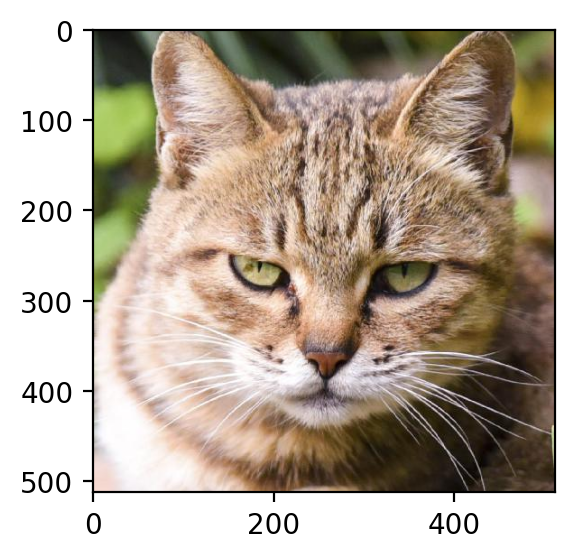

In [31]:
plt.imshow(original_images[2].permute(1,2,0))

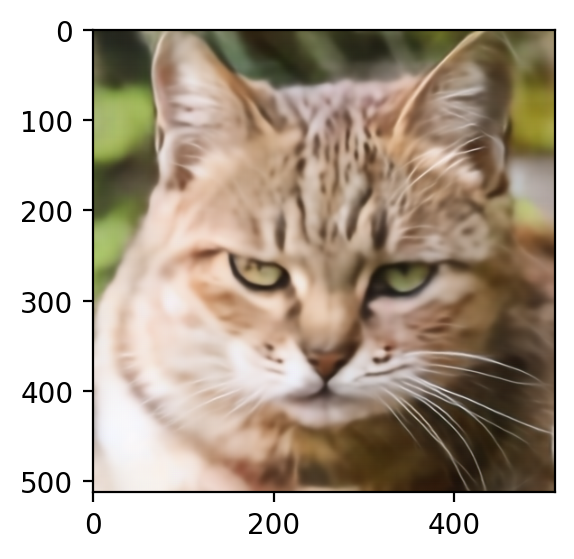

In [32]:
plt.imshow(returned_images[2].permute(1,2,0))

In [19]:
model1 = VariationalAutoencoder(latent_channels=4).to('cuda:1')
model1.load_state_dict(torch.load('./trained_models/diffuserscopy_checkpoint_8.pth'))
model1.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): ResDown(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (conv2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_

In [59]:

import torch
from PIL import Image
import imageio

N = torch.distributions.Normal(0, 1)
img1 = X1[0].unsqueeze(0)*2.0 - 1.0
mu,log_var = model1.encoder(img1.to('cuda:1'))
sigma = torch.exp(0.5*log_var).to('cuda:1')
latent1 = mu+sigma*N.sample(mu.shape).to('cuda:1')

img2 = X1[1].unsqueeze(0)*2.0 - 1.0
mu,log_var = model1.encoder(img2.to('cuda:1'))
sigma = torch.exp(0.5*log_var).to('cuda:1')
latent2 = mu+sigma*N.sample(mu.shape).to('cuda:1')

interpolated_images = []
num_interpolations = 100

# Compute the interpolations
for alpha in torch.linspace(0, 1, num_interpolations):
    interpolated_latnet = latent1 * (1 - alpha) + latent2 * alpha

    interpolated_image = model1.decoder(interpolated_latnet.to('cuda:1'))
    interpolated_image = (interpolated_image / 2 + 0.5).clamp(0, 1)

    # Convert the tensor image to a PIL image
    pil_image = Image.fromarray((interpolated_image.squeeze().detach().cpu().permute(1, 2, 0).numpy() * 255).astype('uint8'))
    interpolated_images.append(pil_image)

imageio.mimsave('interpolation1.gif', interpolated_images, duration=0.5)

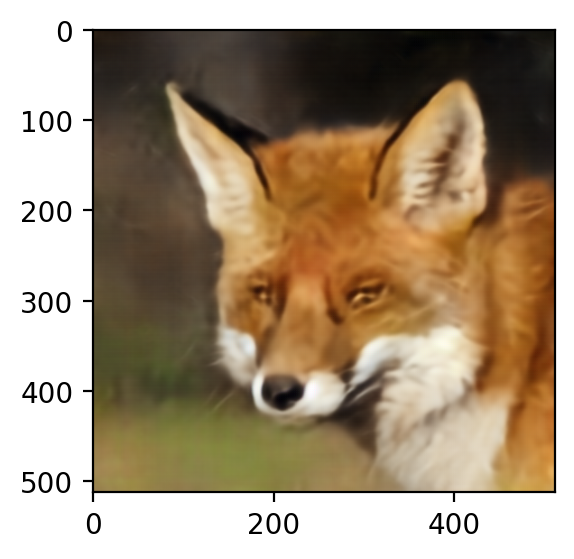

In [53]:
N = torch.distributions.Normal(0, 1)
img = X1[0].unsqueeze(0)*2.0 - 1.0
mu,log_var = model1.encoder(img.to('cuda:1'))
sigma = torch.exp(0.5*log_var).to('cuda:1')
latent = mu+sigma*N.sample(mu.shape).to('cuda:1')

x_hat = model1.decoder(latent.to('cuda:1'))
x_hat = (x_hat / 2 + 0.5).clamp(0, 1)
plt.imshow(x_hat.squeeze().detach().cpu().permute(1,2,0))


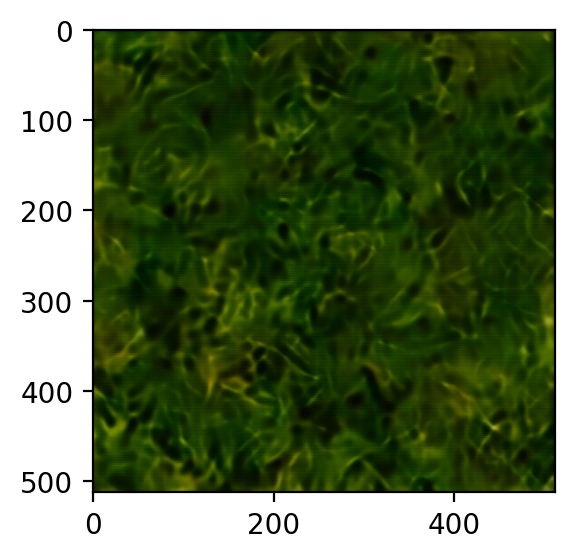

In [55]:

N = torch.distributions.Normal(0, 1)
latent_shape = (1,4,64,64)
latent = N.sample(latent_shape)
x_hat = model1.decoder(latent.to('cuda:1'))
x_hat = (x_hat / 2 + 0.5).clamp(0, 1)
plt.imshow(x_hat.squeeze().detach().cpu().permute(1,2,0))


## Generation


In [15]:
model1.eval()
gen_images = []
N = torch.distributions.Normal(0, 1)
grid_size = 10*10
each_batch = 2
latent_shape = (each_batch,4,64,64)
for i in range(grid_size//each_batch):
    latent = N.sample(latent_shape)
    x_hat = model1.decoder(latent.to('cuda:1'))
    x_hat = (x_hat / 2 + 0.5).clamp(0, 1) 
    gen_images.append(x_hat.detach().cpu())

    

In [16]:
# # Convert lists of tensor batches into single tensors
import torchvision
gen_images = torch.cat(gen_images, dim=0)[:100]  # Taking first 100 images

# Create 10x10 grids
gen_grid = torchvision.utils.make_grid(gen_images, nrow=10, padding=2, normalize=True)

In [17]:
# Display the original images
plt.figure(figsize=(20,20))
plt.title("Generated Images")
plt.imshow(gen_grid.permute(1, 2, 0))
plt.axis('off')
plt.savefig('gen1.png', bbox_inches='tight')
plt.close()

In [15]:
# Display the original images
plt.figure(figsize=(20,20))
plt.title("Original Images")
plt.imshow(original_grid.permute(1, 2, 0))
plt.axis('off')
plt.savefig('original.png', bbox_inches='tight')
plt.close()

In [16]:
# Display the returned images
plt.figure(figsize=(20,20))
plt.title("Returned Images")
plt.imshow(returned_grid.permute(1, 2, 0))
plt.axis('off')
plt.savefig('Reconstructed.png', bbox_inches='tight')
plt.close()

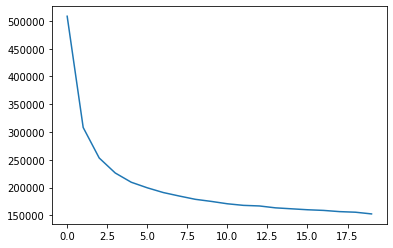

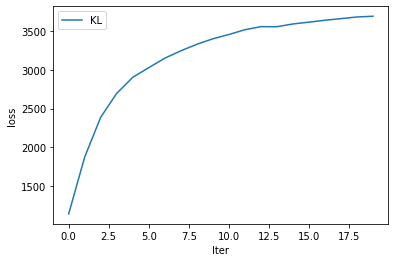

In [42]:
plt.plot(torch.tensor(rec_loss).numpy())
plt.figure()
plt.plot(torch.tensor(KL_loss).numpy())
plt.xlabel('Iter')
plt.ylabel('loss')
plt.legend(['KL'])
#plt.title('Train vs Valid Loss')
 
plt.show()

(512, 512, 3)


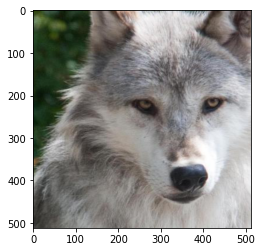

In [43]:
imshow(X[0])

In [44]:
X[0].unsqueeze(0).shape

torch.Size([1, 3, 512, 512])

(512, 512, 3)


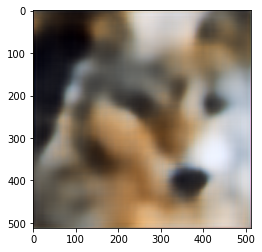

In [45]:
imshow(autoencoder(X[0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())

(512, 512, 3)


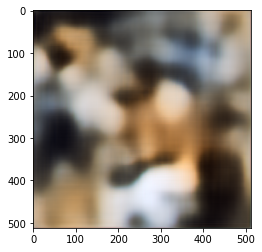

In [46]:

latent = autoencoder.N.sample((1,1024)).to(device)
img = autoencoder.decoder(latent.view(1,1024,1,1))
imshow(img.squeeze(0).detach().cpu())

In [14]:
train_X = torch.zeros(len(train_data),LATENT_DIMS)
train_Y = torch.zeros(len(train_data))

val_X = torch.zeros(len(val_data),LATENT_DIMS)
val_Y = torch.zeros(len(val_data))

for ind,(x, y) in enumerate(train_loader):
    x = x*2.0 - 1.0
    x = x.to('cuda:7') 
    z_mu,z_log_var = model1.encoder(x)
    z_mu = z_mu.view(z_mu.size(0),-1)
    train_X[ind*BATCH_SIZE:(ind+1)*BATCH_SIZE,:LATENT_DIMS] = z_mu.detach()
    #train_X[ind*BATCH_SIZE:(ind+1)*BATCH_SIZE,LATENT_DIMS:] = z_log_var.detach()

    train_Y[ind*BATCH_SIZE:(ind+1)*BATCH_SIZE] = y
    if ind%100==0:
        print(ind)


0
100
200
300
400
500
600
700
800
900


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [18]:

for ind,(x, y) in enumerate(val_loader):
    x = x*2.0 - 1.0
    x = x.to('cuda:7') 
    z_mu,z_log_var = model1.encoder(x)
    z_mu = z_mu.view(z_mu.size(0),-1)
    #print(z_mu.shape,ind*BATCH_SIZE,min(len(val_data),(ind+1)*BATCH_SIZE))

    val_X[ind*BATCH_SIZE:min(len(val_data),(ind+1)*BATCH_SIZE),:LATENT_DIMS] = z_mu.detach()
    #val_X[ind*BATCH_SIZE:min(len(val_data),(ind+1)*BATCH_SIZE),LATENT_DIMS:] = z_log_var.detach()

    val_Y[ind*BATCH_SIZE:min(len(val_data),(ind+1)*BATCH_SIZE)] = y
    if ind%100==0:
        print(ind)

0


In [19]:
train_Y = train_Y.to(torch.int64)
val_Y = val_Y.to(torch.int64)
NUM_CLASSES = 3

In [20]:
torch.save(train_X, './latent_datasets/diffusers/trainX_tensor.pt')
torch.save(train_Y, './latent_datasets/diffusers/trainY_tensor.pt')
torch.save(val_X, './latent_datasets/diffusers/valX_tensor.pt')
torch.save(val_Y, './latent_datasets/diffusers/valY_tensor.pt')
